# Hidden Markov Models

In this homework assignment you will train and evaluate a toy speech recognizer that can recognize 'yes' and 'no'.  As we move into the latter half of the course, note that the assignments will have less and less hand holding.  The goal is for you to become more and more independent, so that you are ready to work independently on the final project.  This assignment should be done in pairs and only one submission needs to be submitted on Gradescope for each team.  In your submission, you should create a single .zip file that contains your jupyter notebook, audio data, annotation data, and generated prediction files.

Please indicate the team member names here: Rafael Burger, Alexa Wright

How many hours you each spent on this assignment: 12 (Rafael), 12 (Alexa)

This assignment will be broken down into 5 main sections:
1. Collect data & annotate (10 points)
2. Train model using manual annotations (20 points)
3. Perform inference on test data (20 points)
4. Infer strong labels on weakly labeled data (20 points)
5. Retrain model and evaluate on test data (20 points)

An additional 10 points will be based on how well organized, commented, and readable your code is.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt
import librosa as lb
from pathlib import Path
from scipy.stats import multivariate_normal
import glob
import warnings

### Part 1: Data Collection & Annotation

For the data collection, you will record 10 audio clips:
- Training data: 5 recordings.  Five of the audio recordings will be for training.  For these recordings, you should say a random sequence of ten yes's or no's.  For example, one recording might be 'yes no yes yes no no yes yes yes no'.  The recordings do not all have to have the same sequence of yes's and no's.  When recording your speaking, please include a variable-length silence in between each word.
- Test data: 5 recordings.  Five of the audio recordings will be for testing.  For these recordings, you should say a variable-length sequence of yes's and no's.  For example, one recording might be 'yes no' and another might be 'no yes yes no no yes no yes'.  Use a variety of different lengths in your sentences.  Again, please include silence in between each word.

All audio recordings should be done by a single person on a single device in the same environment (e.g. recorded on a cell phone in your dorm room).

Once you have recorded the audio, convert them to a format that librosa can read (e.g. wav or mp3) and put them in a folder entitled 'audio/'.  Name the files train1.mp3, train2.mp3, test1.mp3, test2.mp3, etc.

In [3]:
AUDIO_DIR = Path('audio') 
ext = '.mp3' # audio format

In [4]:
def verifyAudioData(indir, file_ext):
    # verifies that all the needed audio files are present

    # check train files
    for i in range(5):
        curfile = Path(AUDIO_DIR, f'train{i+1}').with_suffix(ext)
        assert curfile.is_file(), f'Missing training file {curfile}'

    # check test files
    for i in range(5):
        curfile = Path(AUDIO_DIR, f'test{i+1}').with_suffix(ext)
        assert curfile.is_file(), f'Missing test file {curfile}'

    print('All required audio data files are present!')
    
    return

In [5]:
verifyAudioData(AUDIO_DIR, ext)

All required audio data files are present!


Next you will create two different kinds of annotations: weak labels and strong labels.  

**Weak labels**.  Create two annotation files for the weak labels.  The file train.transcription should look like:

train1.mp3|yes no no yes no yes no no yes no\
train2.mp3|no yes yes yes no no yes no yes no\
...\
train5.mp3|yes no yes yes no no no yes no yes

The file test.transcription should look like:

test1.mp3|yes no\
test2.mp3|no yes yes no yes\
...\
test5.mp3|yes no yes no no yes no yes yes yes

**Strong labels**.  Create one annotation file for train1.mp3 (only) containing strong labels.  The file train1.labels should be in the following format:

0.00 1.37 sil\
1.37 2.60 yes\
2.60 5.20 sil\
5.20 6.30 no\
6.30 8.10 sil\
...\
12.30 13.25 yes\
13.25 15.90 sil

For annotating timestamps, I recommend that you use Audacity.  Note that we are only annotating one file with strong labels because this process is time-consuming!

In [6]:
ANNOT_DIR = Path('annot')
train_transcripts = Path(ANNOT_DIR, 'train.transcription')
test_transcripts = Path(ANNOT_DIR, 'test.transcription')
train1_labels = Path(ANNOT_DIR, 'train1.labels')

In [7]:
def verifyAnnotations():
    # verifies that all of the needed annotation files are present

    assert train_transcripts.is_file(), f'Missing transcription file {train_transcripts}'    
    assert test_transcripts.is_file(), f'Missing transcription file {test_transcripts}'    
    assert train1_labels.is_file(), f'Missing label file {train1_labels}'
    print('All required annotation files are present!')
    
    return

In [8]:
verifyAnnotations()

All required annotation files are present!


Using the above format for your label file, you should be able to visualize your labels alongside the audio in Audacity by selecting File --> Import --> Labels.  An example is shown below.  This type of visualization will be useful in evaluating how accurate your alignments and predictions are.

![Snapshot](labels_snapshot.png)

**Graded**: Please include a similar visualization of your data below.  Make sure you include your image file in your submission!

\[INCLUDE VISUALIZATION HERE\]
![Snapshot](test1image.PNG)

### Part 2: Model Training

In this part, you will train an HMM model based (only) on the label file for train1.mp3.  You must complete the implementations of the functions below.  No unit tests will be provided, though, so make sure to check your own work and verify that they are what you expect!

The function below extracts a feature called mel frequency cepstral coefficients.  Unlike chroma features, which focus on pitch (i.e. fine spectral structure), MFCCs focus on timbre (i.e. rough spectral structure) and are helpful for recognizing speech or distinguishing between different instruments.  You may use the librosa function [librosa.feature.mfcc](https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html) with default arguments.

In [9]:
def computeFeatures(audiofile):
    """
    This function extracts mel frequency cepstral coefficients (MFCCs) from a given audio file.
        
    Inputs
        - audiofile: filepath to the audio recording that you want to extract MFCC features from
        
    Outputs
        - O: an F x N array containing MFCC features, where F corresponds to different features and 
             N corresponds to different audio frames
        - hop: the hop size (in seconds) between adjacent frames
    """

    ### INSERT CODE BELOW ###
    winsize=1024                    # window size   [samples]
    hop_samples=int(winsize//4)     # hop size      [samples]
    y, sr = lb.load(audiofile)      # unpack data and sample rate from audiofile
    hop_seconds = hop_samples / sr  # hop size      [seconds]
    O = lb.feature.mfcc(y=y, win_length = winsize, hop_length = hop_samples ,sr=sr) # compute mfcc features
    return (O, hop_seconds)         # return mfcc features and hop size [seconds]

The function below constructs a mapping between the states and their numeric identifiers.  For ease of grading, please use the following mapping:
- sil -> 0
- Y -> 1
- EH -> 2
- S -> 3
- N -> 4
- OH -> 5

In [10]:
def getStateMapping():
    """
    Returns a mapping between the string and numeric representations of the six different states.
    
    Outputs
      - states: a list that contains the states (in order).  This allows you to map from the numeric identifier
        to the string representation (e.g. states[3])
      - stateStr2id: a dict that maps from the state string representation to its numeric identifier (e.g. stateStr2id['EH'])
    """
    ### INSERT CODE BELOW ###
    #raise NotImplementedError
    states=["sil","Y","EH","S","N","OH"]
    stateStr2id ={
        "sil":0,
        "Y":1,
        "EH":2,
        "S":3,
        "N":4,
        "OH":5     
    }
    
    return (states, stateStr2id)

The function below converts a .labels file into a sequence of states per frame.  You may assume that states in a word have equal duration (e.g. if the word 'yes' lasts 1.2 seconds, you can assume that 'Y', 'EH', and 'S' each have duration 0.4 sec).

In [11]:
def getStatesFromLabelFile(labelfile, hopsize, str2id):
    """
    Reads in a label file and returns a sequence of states for each audio frame.  For any given word, it assumes
    that the constituent states all have equal duration.  For example, if the word 'yes' lasts 1.2 seconds, the constituent
    states 'Y', 'EH', and 'S' are assumed to each have duration 0.4 seconds.
    
    Inputs
      - labelfile: filepath to the .labels or .forcealign file 
      - hopsize: the hop size in seconds between adjacent audio frames
      - str2id: dict that maps from the state's string representation to its numeric representation

    Outputs
      - S: list containing the sequence of numeric states for each audio frame
    """
    ### INSERT CODE BELOW ###
    f = open(labelfile)
    lines = f.readlines()
    
    lastLine = lines[-1].split('\t') # extract the end time of the last label to determine the length of S
    endtime = float(lastLine[1])

    S = np.zeros(int(endtime//hopsize))

    states = ["sil", "Y", "EH", "S", "N", "OH"]

    for i in range(len(lines)):
        line = lines[i].split('\t')   # split the label into [start time, end time, label identifier]
        t1 = float(line[0])            # extract start time (convert from string to float)
        t2 = float(line[1])            # extract end time
        dur = t2 - t1                   # compute duration of label 
        ind = np.zeros(4)
        label = line[2]
        

        if 'sil' in label:           # check if 'sil' is in the label rather than checking equality to deal with inconsistent newline characters
            for i in range(2):  # generate beginning and end indices bc only one silent state
                ind[i] = int((t1 + i*dur) // hopsize)
            S[int(ind[0]): int(ind[1])] = str2id[states[0]]

        elif 'yes' in label:
            for i in range(4):  # generate equally spaced indices to separate 3 'yes' states
                ind[i] = int((t1 + i/3*dur) // hopsize)
            for i in range(3):  # assign states to S matrix
                S[int(ind[i]): int(ind[i+1])] = str2id[states[1+i]]

        elif 'no' in label:
            for i in range(3):  # generate equally spaced indices to separate 2 'no' states
                ind[i] = int((t1 + i/2*dur) // hopsize)
            for i in range(2):  # assign states to S matrix
                S[int(ind[i]): int(ind[i+1])] = str2id[states[i+4]] 
    
    return S

In [12]:
file= "annot/train1.labels"
hop = 0.1
states, str2id = getStateMapping()
S = getStatesFromLabelFile(labelfile = file, hopsize = hop, str2id = str2id)

This is a good place to verify that your functions are producing correct outputs:

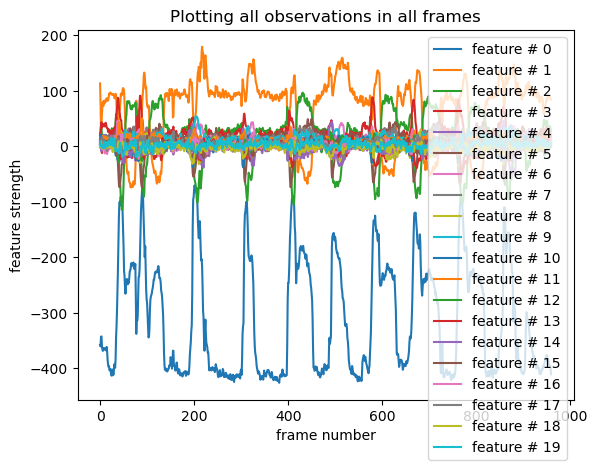

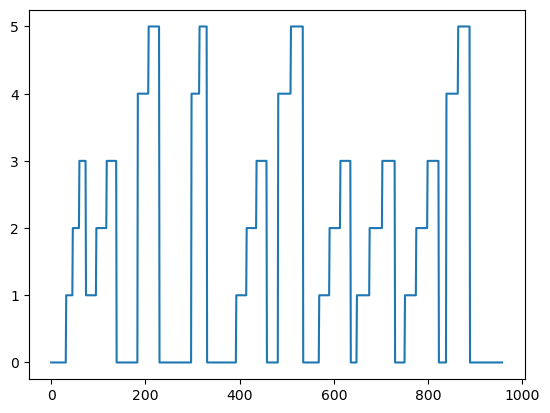

In [13]:
O, hop = computeFeatures(Path(AUDIO_DIR, 'train1.mp3'))
states, stateStr2id = getStateMapping()
S = getStatesFromLabelFile(train1_labels, hop, stateStr2id)

#plotting to see
plt.figure()
plt.title("Plotting all observations in all frames")
plt.ylabel("feature strength")
plt.xlabel("frame number")
c=0
for feat in O:
    plt.plot(feat,label="feature # "+str(c))
    c=c+1
plt.legend()
plt.figure()
plt.plot(S)


The function below trains an HMM given a list of observations (i.e. MFCC feature matrices) and corresponding states.  A few helpful tips:
- In this part of the assignment, you will only train the model on the train1.mp3 example, but your function below should be able to handle multiple training examples so that you can reuse this function in part 5.
- You may assume that recordings always begin in the silent state.
- You should assume that the emission probability model is a multivariate Gaussian model.
- You should decompose this function and define other sub-functions as needed to keep your code neat and organized.

In [14]:
def trainHMM(O_list, S_list, states):
    """
    Trains an HMM given a list of observations and corresponding states.  The HMM assumes a multivariate Gaussian
    emission probability model.

    Inputs
      - O_list: a list of matrices, where each matrix contains the MFCC coefficients for a single training recording
      - S_list: a list of arrays, where each array specifies the states in each audio frame for a single training recording
      - states: a list specifying the states in their string representation

    Outputs
      - A: the state transition probability matrix
      - pi: the distribution of the initial state
      - means: a matrix where each row specifies the mean of the distribution for a single state
      - covars: a 3D tensor where the first index specifies a state, and the remaining two indices specify the covariance 
        matrix for the state's distribution
    """
    ### INSERT CODE BELOW ###

    """
    Note:
    Phases of function:
      1. determine A matrix by going through the entire list of states. Index aij will be # of times there is a state transition from i to j / total number of transitions from i to another state
      2. Determine initial pi by perhaps averaging probabilities over all states, or simply choosing an initial probability
      3. Generate list of means: where mu_i corresponds to the average of all observations for state i
      4. From the means, generate covariance matrices for all i states

    """

    #TODO: This is a cluttered mess, clean it up when possible 
    
    state_names,mapping=getStateMapping()
    num_records=len(O_list) #number of records
    observation_size=len(O_list[0])

    num_states=len(states)
    A_sum = np.zeros((num_states,num_states)) 
    A = np.zeros((num_states,num_states)) 
    observations_sum = np.zeros((num_states,observation_size)) #summed observation for each state
    total_state_count_list=np.zeros(num_states) #total number of times a state appears for all recordings
    means=np.zeros((num_states,observation_size)) #mean of observations across all recordings
    covars=np.zeros((num_states,observation_size,observation_size)) #covariance matrices for all recordings

    #looping through all recordings 
    partitioned_observations=partitionObservations(O_list,S_list, observation_size=observation_size)

    for i in range(num_records):
      S_record=S_list[i]
      O_record=O_list[i]
      A=A+countTransitions(S_record,states) #Sum up all the precursor A matrices to compute values for all recordings
      state_count_list=countNumStates(S_record, states) #list containing the number of time a state appears for this file

      total_state_count_list=total_state_count_list+state_count_list# add this to the count of number of times state appears for all files
      observations_sum=observations_sum+countObservations(O_record,S_record,states) #sum up all the observations to compute the average later
    #computing the A matrix for all recordings
    transitions_sum = np.einsum("ij->i",A) #each element is the total number of transitions from each state index i. This sums the rows.
    for i in range(len(transitions_sum)):
      A[i,:]=A[i,:]/transitions_sum[i] #now divide by the total number of transitions



    #computing average observation and covariances
    for i in range(num_states):
      means[i,:]=observations_sum[i,:]/total_state_count_list[i]  #average observation
      
      curr_obs=np.array(partitioned_observations[i])
      #TODO see if this can be optimized/vectorized 


      #dif_vec = np.array([O_list[k,:,j]-means[i,:] for k in range(num_records) for j in range(np.shape(O_list[k])[1])]).T #vector across records and time
      dif_vec = np.array([curr_obs[j,:]-means[i,:] for j in range(len(curr_obs))]).T

      covar_sum=np.zeros((observation_size,observation_size))
      for k in range(np.shape(dif_vec)[1]):
        outer_prod=np.outer(dif_vec[:,k],dif_vec[:,k])
        covar_sum=covar_sum+outer_prod

        
      covars[i,:,:]=(1/(total_state_count_list[i]-1))*covar_sum


    pi=total_state_count_list/np.sum(total_state_count_list)


    return (A, pi, means, covars)

#sort all the observations into bins based on state type
def partitionObservations(O_list,S_list, observation_size):
  sorted_Observations=[[],[],[],[],[],[]]
  num_records=len(O_list) #number of records
  for i in range(num_records):
    Observation_record=O_list[i]
    State_record=S_list[i]
    num_frames=len(State_record)
    for j in range(num_frames):
      current_state=int(State_record[j])
      current_obs=Observation_record[:,j]
      sorted_Observations[current_state].append(current_obs)
  return sorted_Observations


def findPi(S_list, states):
  """

  """

def countTransitions(S_record,states):
  num_states=len(states)
  num_transitions_mat=np.zeros((num_states,num_states)) 
  for i in range(len(S_record)-1):
    current_state=int(S_record[i]) #string of current state
    next_state=int(S_record[i+1] )#string of next state

    num_transitions_mat[current_state,next_state]=num_transitions_mat[current_state,next_state]+1 
 
  return num_transitions_mat



def countNumStates(S_list,states):
  state_count =np.zeros(len(states)) #keeps count of how many times a state appears
  for i in range(len(S_list)):
    current_state=int(S_list[i])
    state_count[current_state]=state_count[current_state]+1
  return state_count


def countObservations(O_record,S_record,states):
  sum_observations = np.zeros((len(states),np.shape(O_record)[0])) #summed observation for each state
  # print("O_record:countObervsations",np.shape(O_record))
  # print("S_record:countObervsations",np.shape(S_record))
  for i in range(len(S_record)):
    current_state=int(S_record[i])#current state
    current_observation=O_record[:,i]
    sum_observations[current_state,:]=sum_observations[current_state,:]+current_observation #add current observation to running count
  return sum_observations


Use the functions defined above to train an HMM model on the train1.labels file (only).  For grading purposes, please print out the following variables (and make sure your submitted notebook is showing the values): 
- the state transition probability matrix A
- the means for all six states
- the covariance matrix for 'sil'

In [15]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###

audiofile = Path(AUDIO_DIR, "train1.mp3")
labelfile = Path(ANNOT_DIR, "train1.labels")

train1_obs, hop = computeFeatures(audiofile = audiofile) # compute observations and hop size from audio file

states, stateStr2id = getStateMapping() # retrieve list of possible states and mapping between string and integer state representation

train1_states = getStatesFromLabelFile(labelfile = labelfile, hopsize = hop, str2id = stateStr2id) # generate state list for audio file from strong labels

O_list=np.array([train1_obs])
S_list=np.array([train1_states])

A, pi, means, covars = trainHMM(O_list, S_list, states)


### CHANGED THIS CELL TO MARKDOWN SO IT WOULDN'T PLOT OR RUN

train_states_names=[]
for i in range(len(train1_states)):
    
    train_states_names.append(states[int(train1_states[i])])
times=np.array(range(len(train1_states)))*hop
plt.figure(figsize=(10,5))
plt.plot(times,train1_states)
plt.xticks(np.arange(times[0],times[-1],0.5))
plt.show()



### CHANGED THIS CELL TO MARKDOWN SO IT WOULDN'T PLOT OR RUN

print(means[0]) #check to see if the average silent frame looks similar to a known silent frame
print(O_list[0][:,0])



plt.matshow(covars[0])
plt.title("Covariance")
plt.figure()
plt.title("Plotting all observations in all frames")
plt.ylabel("feature strength")
plt.xlabel("frame number")
c=0
for feat in O_list[0]:
    plt.plot(feat,label="feature # "+str(c))
    c=c+1
plt.legend()

plt.figure()
plt.title("Average feature for all states")
plt.xlabel("feature #")
plt.ylabel("feature strength")
c=0
for state in means:
    plt.plot(state,label="state "+str(c)+" "+states[c])
    c=c+1
plt.legend()


**Graded**: Print out A below

In [16]:
A

array([[0.97650131, 0.01305483, 0.        , 0.        , 0.01044386,
        0.        ],
       [0.        , 0.95419847, 0.04580153, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.95419847, 0.04580153, 0.        ,
        0.        ],
       [0.03846154, 0.00769231, 0.        , 0.95384615, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.95652174,
        0.04347826],
       [0.04444444, 0.        , 0.        , 0.        , 0.        ,
        0.95555556]])

**Graded**: Print out the state distribution means below

In [17]:
means

array([[-4.00068771e+02,  9.07281810e+01,  2.27610435e+01,
         2.27935201e+01,  1.25259130e+01,  1.63838478e+01,
         9.15470868e+00,  1.07835291e+01,  5.56201800e+00,
         1.07996634e+01,  4.61305195e+00,  6.39504209e+00,
         1.67721756e+00,  2.90329360e+00, -1.65897526e+00,
         2.36835092e+00,  6.73739975e-01,  3.56804730e+00,
        -1.29386509e+00,  3.87393940e+00],
       [-2.35154457e+02,  8.15141006e+01, -1.01412326e+01,
         4.33034526e+01,  7.34262726e+00, -2.19423592e+01,
         1.40825509e+01,  6.90334800e-01, -2.57736560e+00,
         9.72487044e+00, -6.22558614e+00,  1.25156841e+01,
        -3.68433262e+00, -1.19449810e+01, -1.80965151e+00,
        -1.61406514e+00, -9.54488047e-01,  5.18779684e+00,
        -3.60673428e+00, -1.42947927e+00],
       [-2.25258321e+02,  1.53658334e+01,  3.10831815e+01,
        -2.98850779e+00,  1.31041978e+01,  1.05136127e+01,
         1.51622953e+00,  1.80121326e+01,  2.50224530e+00,
         1.76327166e+01, -4.4

**Graded**: Print out the covariance matrix for 'sil' below

In [18]:
covars[0]

array([[ 3.97815654e+02,  1.10859616e+01, -1.87078925e+02,
        -1.30875680e+01,  1.80821795e+01, -2.25348723e+01,
        -3.20156546e+01,  1.86291235e+00, -1.71842522e+01,
         1.51416390e+01,  1.08260003e+01,  1.26799013e+01,
        -3.16776994e+00, -1.60522502e+01, -8.60837306e-01,
         2.81409643e+01, -1.02427202e+01,  1.93887217e+00,
        -8.58854959e+00, -1.34315198e+01],
       [ 1.10859616e+01,  9.55563011e+01, -2.80660433e+01,
        -3.53487923e+01,  4.24916220e+00, -7.10855989e+00,
         6.09773871e+00, -1.42608165e+01,  6.29535455e+00,
         3.54418795e+00, -6.66031158e-01, -4.57190260e+00,
         4.80698776e+00, -3.72640174e+00,  4.33968892e+00,
        -3.84027041e+00,  5.28360802e+00, -1.07772438e+01,
        -4.57089216e+00, -4.91362163e+00],
       [-1.87078925e+02, -2.80660433e+01,  1.91852870e+02,
         2.86587166e+01, -2.58464013e+01,  2.13233643e+01,
        -3.70061582e-01,  5.10319051e-01, -1.57527656e+00,
        -8.32205345e+00, -9.8

### Part 3: Inference

In this part, we will use our trained model from part 2 to estimate the state sequence on test recordings.  You must complete the implementations of the functions below.  Again, no unit tests will be provided, so make sure to check your own work!

The function below calculates a pairwise similarity matrix, assuming a Gaussian emission probability model.  You may use the scipy implementation of [multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) in your implementation.

In [19]:
# RAFAEL 
def calcSimilarity_multivariateGaussian(O, means, covars):
    """
    Calculates the matrix of likelihoods for a sequence of observations and a set of multivariate Gaussian models.

    Inputs
      - O: an D x N observation matrix, where D is the dimensionality of the feature representation and N is the number
        of observations
      - means: an M x D matrix specifying the distribution means, where M is the number of multivariate Gaussian models 
      - covars: an M x D x D array specifying the distribution covariance matrices, where the first index specifies the model
        and the remaining two indices specify the model's covariance matrix

    Outputs
      - prob: a M x N matrix specifying model likelihoods, where M corresponds to the different models and where N corresponds
        to the different observations
    """
    ### INSERT CODE BELOW ###
    
    M = means.shape[0]  # unpack required matrix dimensions
    N = O.shape[1]      

    prob = np.zeros((M,N))

    for row in range(M):  # loop through models
        model_E = means[row, :]   # unpack current model mean
        model_Sig = covars[row, :, :]   # unpack current model covariance
        gauss_dist = multivariate_normal(mean = model_E, cov = model_Sig)   # generate gaussian distributiuon for current model
        for col in range(N): # loop through audio frames
            prob[row, col] = gauss_dist.pdf(x=O[:,col])
            
    return prob

The function below implements the Viterbi algorithm from scratch.  Since there are lots of implementations of Viterbi online, you should not consult any direct implementations.  If you are unable to complete this part on your own, you may consult an online implementation for a grade deduction.  If you do so, please cite the resource and describe the extent of the assistance so that points may be deducted appropriately.

**Graded**: Please cite any resources you consulted in implementing the function below, and the extent of the assistance: 

We only consulted class notes to implement this function. 

In [20]:
# RAFAEL
def viterbi(prob, A, pi):
    """
    Inputs
      - prob: a M x N matrix specifying model likelihoods, where M is the number of models and N is the number of observations
      - A: an M x M transition probability matrix
      - pi: a length M array specifying the initial state probability distribution
        
    Outputs
      - S_est: the estimated sequence of (numeric) states
    """
    ### INSERT CODE BELOW ###

    lam = 0.1

    M,N = prob.shape

    pi = pi.reshape(M,) # make sure pi is a column vector
    
    #### CONSTRUCT D AND B MATRICES

    D = np.zeros((M, N))  # Allocate cumulative path score matrix D
    B = np.zeros((M, N))  # Allocate backrace matrix B

    D[:,0] = np.log(pi) + np.log(prob[:,0]) # Initialize first column of D
    
    for f in range(1,N): # iterate over all frames (f)
        for s in range(M): # iterate over all possible states (s) for each frame
            transitions = A[:,s] # column vector of transitions from all states -> state s
            p = prob[s,f] # probability of state s occuring in frame f
            scores = D[:,f-1] + np.log(transitions) + lam * np.log(p) # scores = scores from previous frame + transition score + probability
            D[s, f] = np.max(scores)    # assign max of possible scores to cumulative score matrix entry
            B[s, f] = np.argmax(scores) # assign backpointer to be index of max possible score

    #### EXTRACT ESTIMATED PATH THROUGH D
    S_est = np.zeros(N)
    S_est[0] = np.argmax(D[:,-1]) # construct estimated state sequence in reverse order, will flip at end

    for i in range(1,N):
        S_est[i] = B[int(S_est[i-1]),N-i]

    return np.flip(S_est) # flip estimated state sequence to forward orientation and return

Using the two functions above, estimate the state sequence for each test recording and generate the corresponding .labels file (it can have a different extension but should have the same format so as to be readable by Audacity).  Include a visualization of your estimated states alongside the audio in Audacity (as shown above).  You may use as many code cells as needed, and be sure to decompose your code appropriately!

In [21]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###

In [22]:
### FIRST, CREATE FUNCTION FOR ESTIMATING THE STATE SEQUENCE OF A RECORDING

# this really just strings together some of the functions from above 
def estimateStateSequence(test_file, means, covars, A, pi):
    obs, hop = computeFeatures(test_file)
    prob = calcSimilarity_multivariateGaussian(O = obs, means = means, covars = covars)
    S_est = viterbi(prob = prob, A = A, pi = pi)
    return S_est, hop


In [23]:
### DEFINE FUNCTION TO COMPILE LIST OF STATE-CHANGE INDICES FOR A STATE SEQUENCE
def getStateChangeIndices(S_est):
    indices = [0]
    for i in range(1,len(S_est)):
        if S_est[i-1] != S_est[i]:
            indices.append(i)
    indices.append(i)
    return indices

In [24]:
### DEFINE FUNCTION TO CONVERT LIST OF INDICES TO TIMESTAMPS
def convertToTimesteps(indices, hop):
    timesteps = np.array(indices) * hop
    return timesteps

In [25]:
### DEFINE FUNCTION TO GENERATE STATE ORDER LIST (COLLAPSE ADJACENT REPEATED VALUES OF S_EST)
# Note: produced lists holds state string representations

def collapseStateSequence(S_est):
    S_est_collapsed = [states[int(S_est[0])]]
    for i in range(1,len(S_est)):
        if S_est[i] != S_est[i-1]:
            S_est_collapsed.append(states[int(S_est[i])])
    return S_est_collapsed

In [26]:
### DEFINE FUNCTIONS FOR WRITING TO .LABELS FILE

# function to write one label (one line) to specified file
def writeLabel(label_indicator, label_timestep, file):
    start, stop = (label_timestep[0], label_timestep[1])
    line = "%f\t%f\t%s\n" % (start, stop, label_indicator)
    file.write(line)

# function to write a label file for the given indicators, timesteps, and filename
def writeLabelFile(state_list, state_timesteps, file_name):
    f = open(file_name, 'w')
    for i in range(len(state_list)):
        writeLabel(state_list[i], state_timesteps[i:i+2], f)
    f.close()

# function to generate a list of label file names
def generateLabelFileNames(prefix, num_trials, suffix):
    fnames = []
    for i in range(num_trials):
        fname = Path(ANNOT_DIR, '%s%d%s'%(prefix, i+1, suffix))
        fnames.append(fname)
    return fnames

In [27]:
### WRITE LABELS FILES FOR TEST AUDIO FILES
fileID = 'test'
files = glob.glob('audio/%s*.mp3' % fileID)
num_files = len(files)
file_names = generateLabelFileNames(fileID, num_files, '_initial_estimation.labels')
for i in range(num_files):
    S_est, hop = estimateStateSequence(test_file = files[i], means = means, covars = covars, A = A, pi = pi)
    state_change_indices = getStateChangeIndices(S_est=S_est)
    state_change_timesteps = convertToTimesteps(indices=state_change_indices, hop=hop)
    state_order_list = collapseStateSequence(S_est=S_est)
    writeLabelFile(state_order_list, state_change_timesteps, file_names[i])

Comment on what you observe in your estimated state sequence, and propose some ideas on how you might improve the system.

**Graded**: 

Below you can see a series of images showing various test audio files displayed in Audacity with the estimated labels overlaid. To begin with, let's look at the audio record and estimated states for test1.mp3

![Snapshot](test1labelsoverlaid.png)

As you can see, the labels correctly capture each "yes" as a "yes" and each "no" as a "no". There seems to be an issue during some of the silences, however, where the speech recognizer accidentally assigns some of the silent portions of the recording to be very quick "yes"s and "no"s. Let's zoom in on the same recording to take a closer look: 

![Snapshot](test1labelsoverlaid_zoom.png)

I've zoomed in on a "yes" portion of the audio file. That is to say, upon listening back, the speaker actually says "yes" in this portion of the recording. The algorithm correctly recognizes this segment as a unbroken string of "Y" states followed by "EH"s and finally followed by "S"s. However, at the very end, when we would hope that the algorithm would estimate silence, it squeezes a quick "yes" in. Note that at this moment, the signal amplitude is becoming very small, however it is not yet as low as "true" silence. This suggests that our algorithm tends to perform poorly during periods of low signal amplitude, tending to identify them as non-silence instead of silence. 

Let's take a look at the next record (test3.mp3) and see how the results compare: 

![Snapshot](test3labelsoverlaid.png)

We see the same thing! Towards the beginning, the algorithm incorrectly identifies a "no" during a silent stretch, and incorrectly calls silence a "yes" just before the end of file. Let's zoom in on the end of file. 

![Snapshot](test3labelsoverlaid_zoom.png)

Zooming in shows the same story that we noted for test1.mp3. In this period of the recording, background noise prevents the silent state from being recorded as truly silent. Small signal perturbations around zero signal amplitude are incorrectly identified as words. 


### Part 4: Forced Alignment

In this part, you will perform forced alignment to determine the correspondence between the states in a given word-level transcription and the corresponding audio recording.  Your goal is to implement the function below, and then use it to determine the state-level alignment for train1.mp3.  Make sure to decompose your function appropriately!

In [28]:
def forcedAlignment(audiofile, word_transcript, model, stateStr2id):
  """
  Performs forced alignment between a given word-level transcription and the corresponding audio recording.
  Inputs
    - audiofile: filepath to the audio recording
    - word_transcript: a string indicating the word-level transcription.  The transcription should only
      contain 'yes' and 'no'; the function will raise an error if it contains anything other than these two words
    - model: tuple of (A, pi, means, covars) specifying the trained HMM
    - stateStr2id: a dict that maps from the state string representation to its numeric identifier (e.g. stateStr2id['EH'])
  Output
    - alignment: an array specifying the coordinates of the forced alignment
  """
  ### INSERT CODE BELOW ###
  A,pi,means,covars=model
  features,hopsecs=computeFeatures(audiofile)
  feat_num, frames=features.shape
  string_array=word_transcript.split(" ")
  str_array2state,state_str_arr=expandWords(string_array)
  state_arr_len=len(state_str_arr)
  transition_indices=getTransitionIndices(state_str_arr,stateStr2id) #each 
  lam=1 #lambda param
  similarity_mat=calcSimilarity_multivariateGaussian(features, means, covars)# provides conditional probabilities for observations and states
  B,D=computeCostPath(features,str_array2state,state_str_arr,model,transition_indices)
  path=backtrace(B,state_str_arr)

  """
  TODO: FIGURE OUT WHAT ALIGNMENT FORMAT SHOULD BE. FOR NOW, I WILL RETURN PATH
  """
  return path
  
           
def computeCostPath(features,str_array2state,state_str_arr,model,transition_indices):
  A,pi,means,covars=model
  num_feats, frames=features.shape
  lam=1 #lambda param
  state_arr_len=len(state_str_arr)
  D=-np.inf*np.ones((state_arr_len,frames))
  B=np.zeros((state_arr_len,frames))
  similarity_mat=calcSimilarity_multivariateGaussian(features, means, covars)# provides conditional probabilities for observations and states
  #initialize first column
  
  for i in range(state_arr_len):
    p_map=str_array2state[i] #unwrapped state index wrapped back to state space
    conditional_p=similarity_mat[p_map,0] #conditional probability for state given current state wrapped back state
    current_t_idx=transition_indices[i] #grab mapping from unwrapped state to state matrix indices 
    
    A_mat_probs=A[current_t_idx[0],current_t_idx[1]]

    D[i,0]=np.emath.log(A_mat_probs)+lam*np.emath.log(conditional_p)
    

  for i in range(0,state_arr_len):
     for j in range(i+1,frames):
        p_map=str_array2state[i] #unwrapped state index wrapped back to state space
        conditional_p=similarity_mat[p_map,j] #conditional probability for state given current state wrapped back state
        current_t_idx=transition_indices[i]#indices of current unwrapped state in the A matrix
        A_mat_prob=A[current_t_idx[0],current_t_idx[1]] #conditional probability from the state matrix
        cur_state_p=np.emath.log(A_mat_prob)+lam*np.emath.log(conditional_p) #probability score to be tacked on to path

        #play around with just having probs be the a mat probs
        if(i==0): #case of being in first row, can only come from previous frame horizontally
           D[i,j]=D[i,j-1]+cur_state_p
           #B[i,j]=0 for horizontal, 1 for diagonal
           B[i,j]=0
           #todo: add paths

        else: #case of being in any other row besides first
           paths=np.array([D[i,j-1],D[i-1,j-1]])
           max_path_idx=np.argmax(paths) #todo: b path matrix
           max_path=np.max(paths)
           D[i,j]=max_path+cur_state_p  
           B[i,j]=max_path_idx
  return B,D        
        
def backtrace(B,state_str_arr):
  path=[]
  height,wid=B.shape  
  current_pos=height-1#path should be in upper right corner
  for i in range(wid-1,0,-1):#traverse in time

    path.append(state_str_arr[current_pos])
    next_move=B[current_pos,i] #next in path
    current_pos=int(current_pos-next_move)
  path=np.array(path)
  path=np.flip(path)
  return path

def transcriptionFromFile(filename,offset):
    f = open(filename)
    lines = f.readlines()
    
    temp = lines[offset].split('|')
    temp = temp[-1].split('\n')
    ret_str=temp[0]
    return ret_str

def expandWords(strlist):
  expandedlist=["sil"]
  for i in range(len(strlist)):
      if(strlist[i]=="yes"):
        expandedlist.append("Y")
        expandedlist.append("EH")
        expandedlist.append("S")
        expandedlist.append("sil")
      elif (strlist[i]=='no'):
        expandedlist.append("N")
        expandedlist.append("OH")
        expandedlist.append("sil")
      elif (strlist[i] == ''):
         print("Empty string encountered and ignored in transcription file.")
      else: 
         print("Warning! Forcealign transcription string contains unregistered word (%s)" %strlist[i])

  states, stateStr2id=getStateMapping()
  expanded_to_state={ i:stateStr2id[expandedlist[i]] for i in range(len(expandedlist))}
  return expanded_to_state,expandedlist 
     
def getTransitionIndices(state_list_str,strmap):
  cur_state=state_list_str[0]
  indices=[[strmap[cur_state],strmap[cur_state]]] #initialize first one as sil->sil
  for i in range(len(state_list_str)-1):
    cur_state=state_list_str[i]
    next_state=state_list_str[i+1]
    indices.append([strmap[cur_state],strmap[next_state]]) 
  return np.array(indices)      

Once you have implemented the forced alignment function above, use it to estimate the state-level alignment for train1.mp3.  Visualize the predicted alignment alongside the audio in Audacity, and also include the word-level alignment from part 1 (that you manually created).  Comment on how the forced alignmend method improves the quality of the alignment.

In [29]:
### DEFINE FUNCTIONS TO STREAMLINE FORCEALIGN FILE GENERATION

def generateForcealignFilesFromTranscription(trans_file, audio_files, offset, alignment_fname):

    trans_str = transcriptionFromFile(trans_file, offset)
    path = forcedAlignment(audio_files[offset], trans_str, (A, pi, means, covars), stateStr2id)
    alignment_states = getStateListForcealign(path)
    alignment_coords = getStateChangeIndices(path)
    alignment_timesteps = convertToTimesteps(alignment_coords, hop)
    writeLabelFile(alignment_states, alignment_timesteps, alignment_fname)

# This function should return a list that displays the same data as the transcription string, but broken down from words to states. 
# Operates by eliminating repeat values from the path array. 
def getStateListForcealign(path):
    state_list = [path[0]]
    for i in range(1,len(path)):
        if path[i] != path[i-1]:
            state_list.append(path[i])
    return state_list

In [30]:
states, stateStr2id = getStateMapping()

train_trans_file = Path(ANNOT_DIR, "train.transcription")
train_audio_files = glob.glob('audio/train*.mp3')
test_fname = Path(ANNOT_DIR, "train1.forcealign")

generateForcealignFilesFromTranscription(trans_file=train_trans_file, audio_files=train_audio_files, offset=0, alignment_fname=test_fname)

**Graded**: Include the visualization below and comment on what you observe.

![Snapshot](train1labelcomparison.png)

In the above image, I've displayed both the estimated labels (generated using forced alignment) and the strong labels (generated manually) next to the audio data for train1.mp3. As you can see, the estimated labels are close to a perfect match with the strong labels!

### Part 5: Retrain Model

In the last part of the assignment, you will use your initial model from part 2, perform forced alignment to generate .forcealign files for all weakly labeled training data, re-train your HMM, and then perform inference on the test data with the new model.  Provide a snapshot in Audacity comparing the predictions from part 3 and part 5 on a single test file.  Comment on any differences you observe, what the re-trained model is doing well, and where the re-trained model is making errors.

In [31]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###

In [32]:
# START BY GENERATING .FORCEALIGN FILES FOR THE REMAINING TRAINING DATA

train_trans_file = Path(ANNOT_DIR, "train.transcription")

train_audio_files = glob.glob('%s/train*.mp3' % AUDIO_DIR)
train_forcealign_filenames = generateLabelFileNames(prefix="train", num_trials=5, suffix=".forcealign")

for i in range(5):
    generateForcealignFilesFromTranscription(trans_file=train_trans_file, audio_files=train_audio_files, offset=i, alignment_fname=train_forcealign_filenames[i])

In [33]:
### DEFINE FUNCTION TO GET STATES FROM .FORCEALIGN FILE
def getStatesFromForcealignFile(file_name, hopsize, states):
    f = open(file_name)
    lines = f.readlines()
    
    lastLine = lines[-1].split('\t') # extract the end time of the last label to determine the length of S
    endtime = float(lastLine[1])

    S = np.zeros(int(endtime//hopsize))


    for i in range(len(lines)):
        line = lines[i].split('\t')   # split the label into [start time, end time, label identifier]

        t1 = float(line[0])            # extract start time (convert from string to float)
        t2 = float(line[1])            # extract end time

        ind1 = int(t1 // hopsize)
        ind2 = int(t2 // hopsize)

        temp = line[2].split('\n') # remove newline character if it exists
        state_str = temp[0]
        
        for i in range(len(states)):
            #print('State_str: %s, Cur_state: %s, Equal? %d' % (state_str, states[i], states[i] == state_str))
            if states[i] == state_str:
                S[ind1:ind2] = str2id[states[i]]
    return S

In [34]:
### CREATE O_LIST AND S_LIST TO TRAIN ON, and RETRAIN THE MODEL! 
states, stateStr2id = getStateMapping() # retrieve list of possible states and mapping between string and integer state representation

S_list = []
O_list = []

for i in range(5):
    O, hop = computeFeatures(audiofile = train_audio_files[i])
    S = getStatesFromForcealignFile(file_name = train_forcealign_filenames[i], hopsize = hop, states = states)
    
    O_list.append(O)
    S_list.append(S)


A_retrained, pi_retrained, means_retrained, covars_retrained = trainHMM(O_list, S_list, states)

In [35]:
### Perform inference on the 5 test files

files = glob.glob('audio/test*.mp3')
num_files = len(files)
file_names = generateLabelFileNames(fileID, num_files, '_retrained_estimation.labels')
for i in range(num_files):
    S_est, hop = estimateStateSequence(test_file = files[i], means = means_retrained, covars = covars_retrained, A = A_retrained, pi = pi_retrained)
    state_change_indices = getStateChangeIndices(S_est=S_est)
    state_change_timesteps = convertToTimesteps(indices=state_change_indices, hop=hop)
    state_order_list = collapseStateSequence(S_est=S_est)
    writeLabelFile(state_order_list, state_change_timesteps, file_names[i])

**Graded**:  
\[INSERT VISUALIZATION & COMMENTS HERE\]

Below you can see a screenshot of one of the audio files (test 2) displayed with overlaid labels, generated from the retrained model. 

![Snapshot](test2retrainedlabelsoverlaid.png)

It is almost entirely correct! But this image is very zoomed out, so I don't expect you to believe me. Let's zoom in. 

![Snapshot](test2retrainedlabelsoverlaid_zoom.png)

You can see that this model correctly identifies two successive "yes"s in this portion of the audio file. You also probably notice, however, that it stumbles into the same problem that the original model did: accidentally identifying silence as a "no". We chose to show this segment of the audio file to illustrate that the retrained model did not entirely overcome this problem, however it is worth noting that this error seems to occur less frequently with the new model. After retraining, we were able to further reduce the frequency of this error by reducing the lambda value in our viterbi algorithm. This caused the algorithm to trust the observations less, leading to a decreased likelihood of a small perturbation during silence to lead to an incorrect algorithm prediction. 

The remaining test files, included below, show similar results. 

### Test 1
![Snapshot](test1retrainedlabelsoverlaid.png)

### Test 3
![Snapshot](test3retrainedlabelsoverlaid.png)

### Test 4
![Snapshot](test4retrainedlabelsoverlaid.png)

### Test 5
![Snapshot](test5retrainedlabelsoverlaid.png)

As you can see, these files show nearly perfect accuracy to the states we expect based on the audio files, with only one additional error occuring over files 1,3,4, and 5. This error occurs at the beginning of test file four, in which silence is accidentally labelled "no" for a moment. This is an improvement over the model accuracy trained on only one record. 